# CycleGan

## Utils

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Hyper Parameters

In [3]:
# Define the standard image size.
orig_img_size = (320, 320)
input_img_size = (320, 320, 3)

shuffle_size = 256
batch_size = 1

## Preprocessing

In [4]:
def preprocess_img(img):
    img = tf.image.resize(img, [*orig_img_size])
    img = tf.cast(img, dtype=tf.float32)
    return (img / 255)

## Load Best Model

In [5]:
def load_best_model(path):
    import shutil 
    import os.path
    from zipfile import ZipFile
    import pickle
    
    !gdown --id 1OHlZEKmqqAqf6PsYZ1NOg_qx9vegNuQk
    with ZipFile(f"{path}.zip", 'r') as zObject:
        zObject.extractall(path=path)

    return tf.keras.models.load_model(f'{path}')

## Making a single prediction

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OHlZEKmqqAqf6PsYZ1NOg_qx9vegNuQk
To: /content/BestModel-320x320.zip
100% 42.4M/42.4M [00:00<00:00, 97.6MB/s]


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Saving 6764.jpg to 6764.jpg
(None, 320, 320, 3)


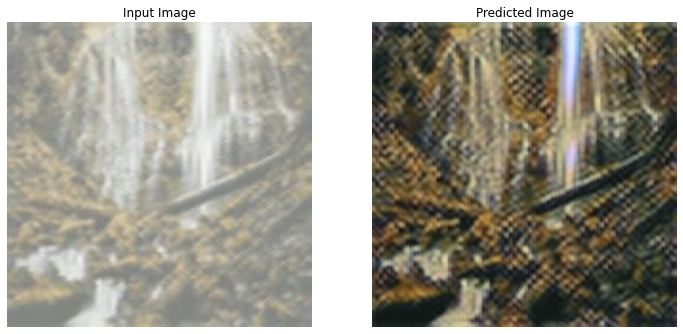

In [6]:
def generate_images(model, 
                    test_input):
    print(model.input_shape)
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_input[0])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(prediction[0])
    plt.title('Predicted Image')
    plt.axis('off')

    plt.show()

best_model = load_best_model("BestModel-320x320")

from google.colab import files
from PIL import Image

test_images = files.upload()
for imageName in test_images.keys():
  test_image = np.expand_dims(np.array(Image.open(imageName)), axis=0)
  generate_images(best_model, preprocess_img(test_image))

# Neural Style Transfer

## Imports

In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import math
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
from google.colab import files

## Define NeuralStyleTransfer base class

In [ ]:
class NeuralStyleTransfer:
  RESULT_PREFIX = "monet_generated"

  def generate_image(self, base_image, style_image, patience=3, delta=20, max_iterations=10000, debug=False):
    prev_loss = float('inf')
    stagnation_count = 0

    optimizer = self.optimizer(*self.optimizer_args, **self.optimizer_kwargs)

    pre_base_image = self.preprocess_image(base_image)
    pre_style_reference_image = self.preprocess_image(style_image)
    combination_image = tf.Variable(self.preprocess_image(base_image))

    for i in range(max_iterations + 1):
      loss, grads = self.compute_loss_and_grads(combination_image, pre_base_image, pre_style_reference_image)
      optimizer.apply_gradients([(grads, combination_image)])

      if i % 100 == 0:
        if debug:
          print("Iteration %d: loss=%.2f" % (i, loss))
        
        img = self.deprocess_image(combination_image.numpy())
        fname = self.RESULT_PREFIX + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

        if loss >= prev_loss - delta:
          stagnation_count += 1
        else:
          stagnation_count = 0

        if stagnation_count >= patience:
          if debug:
            print(f'Early stopping after {i + 1} iterations.')
          return fname
      
        prev_loss = loss

    return fname;

  def generate(self, images_dir, styles_dir, limit=None, patience=3, delta=20, max_iterations=10000, debug=False):
    for base_image_path,style_image_path in self.get_paths(images_dir, styles_dir, limit):
      base_image = self.load_image(base_image_path)
      style_reference_image = self.load_image(style_image_path)
      generated_image_path = self.generate_image(base_image, style_reference_image, patience, delta, max_iterations, debug)
      self.show_images(base_image_path, style_image_path, generated_image_path)

  @staticmethod
  def get_paths(images_dir, styles_dir, limit=None):
    images = os.listdir(images_dir)

    if limit:
      images = images[:limit] if limit < len(images) else images

    for image in images:
      style_image_filename = random.choice(os.listdir(styles_dir))
      base_image_path = os.path.join(images_dir, image)
      style_image_path = os.path.join(styles_dir, style_image_filename)
      yield base_image_path, style_image_path

  def load_image(self, image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(self.gen_img_height, self.gen_img_width)
    )
    return img

  def preprocess_image(self, img):
      img = keras.preprocessing.image.img_to_array(img)
      img = np.expand_dims(img, axis=0)
      img = tf.keras.applications.vgg19.preprocess_input(img)
      return tf.convert_to_tensor(img)

  def compute_loss_and_grads(self, combination_image, base_image, style_reference_image):
      with tf.GradientTape() as tape:
        loss = self.compute_loss(combination_image, base_image, style_reference_image)
      grads = tape.gradient(loss, combination_image)
      return loss, grads

  def compute_loss(self, combination_image, base_image, style_reference_image):
      input_tensor = tf.concat(
          [base_image, style_reference_image, combination_image], axis=0
      )
      features = self.feature_extractor(input_tensor)

      # Initialize the loss
      loss = tf.zeros(shape=())

      # Add content loss
      layer_features = features[self.content_layer_name]
      base_image_features = layer_features[0, :, :, :]
      combination_features = layer_features[2, :, :, :]
      loss = loss + self.content_weight * self.content_loss(
          base_image_features, combination_features
      )

      # Add style loss
      for layer_name in self.style_layer_names:
          layer_features = features[layer_name]
          style_reference_features = layer_features[1, :, :, :]
          combination_features = layer_features[2, :, :, :]
          sl = self.style_loss(style_reference_features, combination_features, (self.gen_img_height, self.gen_img_width))
          loss += (self.style_weight / len(self.style_layer_names)) * sl

      # Add total variation loss
      loss += self.total_variation_weight * self.total_variation_loss(combination_image, (self.gen_img_height, self.gen_img_width))
      return loss

  def content_loss(self, base, combination):
    return tf.reduce_sum(tf.square(combination - base))

  @staticmethod
  def style_loss(style, combination, img_shape):
    S = NeuralStyleTransfer.gram_matrix(style)
    C = NeuralStyleTransfer.gram_matrix(combination)
    channels = 3
    size = img_shape[0] * img_shape[1]
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

  @staticmethod
  def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

  @staticmethod
  def total_variation_loss(x, img_shape):
    a = tf.square(
        x[:, : img_shape[0] - 1, : img_shape[1] - 1, :] - x[:, 1:, : img_shape[1] - 1, :]
    )
    b = tf.square(
        x[:, : img_shape[0] - 1, : img_shape[1] - 1, :] - x[:, : img_shape[0] - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))
    
  def deprocess_image(self, x):
      x = x.reshape((self.gen_img_height, self.gen_img_width, 3))

      # Inverse of vgg19 preprocess step
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      
      # 'BGR'->'RGB'
      x = x[:, :, ::-1]
      x = np.clip(x, 0, 255).astype("uint8")

      return x

  @staticmethod
  def show_images(image, style, generated_image):
    img1 = mpimg.imread(image)
    img2 = mpimg.imread(style)
    img3 = mpimg.imread(generated_image)

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(img1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].axis('off')

    plt.show()

## Download Model

In [ ]:
!gdown --id 1y6fo6fHivS2uZ_Ufk9F3tMp8cSmHIl4h

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1y6fo6fHivS2uZ_Ufk9F3tMp8cSmHIl4h
To: /content/nst.model.obj
100% 80.2M/80.2M [00:01<00:00, 50.2MB/s]


In [ ]:
%%capture
with open('nst.model.obj', 'rb') as f:
  nst_model = pickle.load(f)

## Get Images

In [ ]:
from google.colab import files
from PIL import Image

!rm -rf images
!rm -rf monet
!mkdir images
!mkdir monet

print("upload images to translate")
test_images = files.upload()
for path, data in test_images.items():
  with open(f'images/{path}', 'wb') as f:
    f.write(data)

print("upload style")
monet = files.upload()
for path, data in monet.items():
  with open(f'monet/{path}', 'wb') as f:
    f.write(data)

upload images to translate


Saving 012df5ce29.jpg to 012df5ce29 (2).jpg
upload style


Saving 000c1e3bff.jpg to 000c1e3bff (3).jpg


## Generate Image

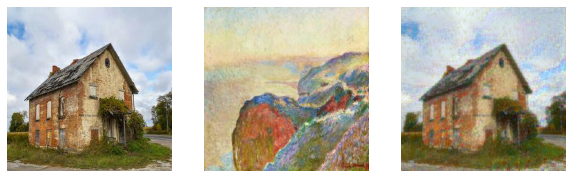

In [ ]:
nst_model.generate('images', 'monet')